In [ ]:
'''
FloodFill modified to traverse the entire image and output different color.
'''

In [183]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [222]:
def get_unique_colors(img):
    return (np.unique(img.reshape(-1, img.shape[2]), axis=0))

def getNextNewColor(newColor, oldColors):
    newColor = (np.random.choice(range(256), size=3))
    while np.any([np.all(uc == newColor) for uc in usedColors]): # if newColor matches any of the oldColors
        newColor = (np.random.choice(range(256), size=3))
    return newColor

def floodfill(surface, x, y, oldColors, usedColors):
    if surface[x][y] not in oldColors: # Has new color already. No need to look.
        return surface, usedColors

    colorOfFocus = surface[x][y].copy()
    newColor = getNextNewColor(0, usedColors)
    usedColors = np.append(usedColors, newColor)

    # Add first coord into stack
    theStack = [(x, y)]
    
    while len(theStack) > 0:
        x, y = theStack.pop()
        
        if x < 0 or x > surface.shape[0]-1 or y < 0 or y > surface.shape[1]-1: # Out of Bounds
            continue
        
        if np.all(surface[x][y] == colorOfFocus):
            surface[x][y] = newColor
            theStack.append((x+1, y))  # right
            theStack.append((x-1, y))  # left
            theStack.append((x, y+1))  # down
            theStack.append((x, y-1))  # up

    return surface, usedColors

def flood_fill_multi(img, debug=False):
    oldColors = get_unique_colors(img)
    usedColors = get_unique_colors(img)
    
    if debug:
        print("Used Colors")
        plt.imshow(usedColors)
        plt.show()

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img, usedColors = floodfill(img, i, j, oldColors, usedColors)

    return img

Orig img


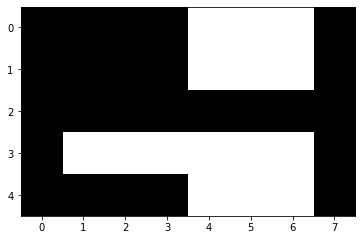

FloodFill | after


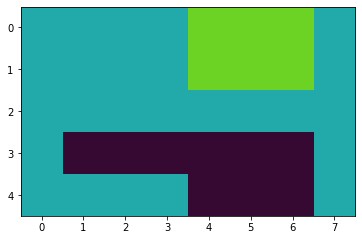

In [225]:
a = np.array([[(0,0,0), (0,0,0), (0,0,0), (0,0,0), (255,255,255), (255,255,255), (255,255,255), (0,0,0)],
             [(0,0,0), (0,0,0), (0,0,0), (0,0,0), (255,255,255), (255,255,255), (255,255,255), (0,0,0)],
             [(0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0)],
             [(0,0,0), (255,255,255), (255,255,255), (255,255,255), (255,255,255), (255,255,255), (255,255,255), (0,0,0)],
             [(0,0,0), (0,0,0), (0,0,0), (0,0,0), (255,255,255), (255,255,255), (255,255,255), (0,0,0)]])

print("Orig img")
plt.imshow(a)
plt.show()

a = flood_fill_multi(a, debug=False)

print("FloodFill | after")
plt.imshow(a)
plt.show()